In [130]:
import time
import os
import mediapipe as mp
import matplotlib.pyplot as plt
from skimage import measure
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import sklearn.cluster
import itertools
import statistics
import cv2
import scipy
import plotly.graph_objs as go
import colorsys
import kociemba

Populating the interactive namespace from numpy and matplotlib


In [167]:
kociemba.solve('DRLUUBFBRBLURRLRUBLRDDFDLFUFUFFDBRDUBRUFLLFDDBFLUBLRBD')
#kociemba.solve('UFRLUUFUBUFRDRRBLLDDLFFFRDBLBFBDRBDLURDRLBRLDFBUUBUFLD')

ValueError: Error. Probably cubestring is invalid

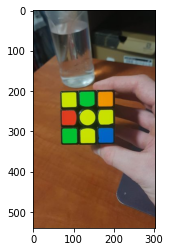

(540, 304, 3)


In [132]:
path = "cub1.jpg"

orig_img = cv2.imread(path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
#plt.imshow(img)
plt.show()
print(np.shape(img))



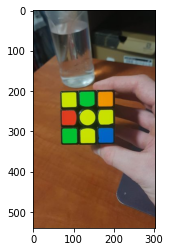

In [133]:
r = img[::20,::20,0].flatten() #here you only plot every 20th pixel
g = img[::20,::20,1].flatten()
b = img[::20,::20,2].flatten()
np.shape(r)

#img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(img)

I have to recognize multiple, unknown shaded colors, so color filtering is not really an option here.

In [134]:
K = 6
rgb = img.reshape((-1,3))
kmeans = sklearn.cluster.KMeans(n_clusters=K).fit(rgb)

kmeans = sklearn.cluster.KMeans(n_clusters=K,init=kmeans.cluster_centers_,n_init=1).fit(rgb)
#print(np.shape(img))
pred = kmeans.predict(rgb)
res = pred.reshape((np.shape(img)[0],np.shape(img)[1]))
np.shape(res)
regions = measure.label(res,connectivity=1,background=-10)
props = measure.regionprops(regions)


meanarea 1274.0 meanside 35
areas [540, 1290, 1260, 1291, 1156, 1255, 1304, 1288, 1312, 1256]
#regions:  10


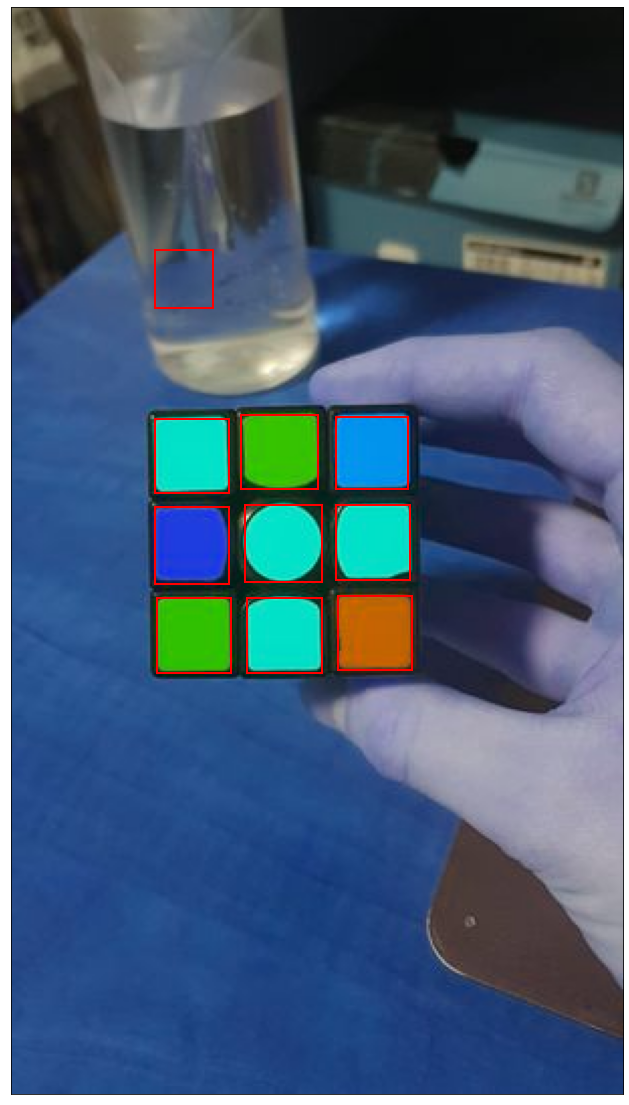

In [135]:
regcount = 0
aspects = []
areas = []
cut_cubies = []


fig, (ax1) = plt.subplots(1,figsize=(20,20))
plt.xticks([]),plt.yticks([])
ax1.imshow(orig_img)
for region in measure.regionprops(regions):
    if region.area < 500 or region.area > res.shape[0]*res.shape[1]*0.05 :
        continue
    minRow, minCol, maxRow, maxCol = region.bbox
    aspect = (maxCol-minCol) / (maxRow-minRow)
    if aspect > 1.1 or aspect < 0.9:
        continue
    areas.append(region.area)
    
    minRow, minCol, maxRow, maxCol = region.bbox
    rectBorder = matplotlib.patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
    cut_cubies.append([minRow, minCol, maxRow, maxCol])
    ax1.add_patch(rectBorder)
    regcount += 1
    ##print(abs(region.area-meanarea))

meanarea = np.median(areas)
meanside = int(np.sqrt(meanarea))
print("meanarea", meanarea, "meanside", meanside)
print("areas",areas)
print("#regions: ", regcount)
plt.show()

In [136]:
def clustering(img):
    K= 6
    aspects = []
    areas = []
    cut_cubies = []

    rgb = img.reshape((-1,3))
    kmeans = sklearn.cluster.KMeans(n_clusters=K).fit(rgb)
    kmeans = sklearn.cluster.KMeans(n_clusters=K,init=kmeans.cluster_centers_,n_init=1).fit(rgb)
    #print(np.shape(img))
    pred = kmeans.predict(rgb)
    res = pred.reshape((np.shape(img)[0],np.shape(img)[1]))
    np.shape(res)
    regions = measure.label(res,connectivity=1,background=-10)


    for region in measure.regionprops(regions):
        if region.area < 500 or region.area > res.shape[0]*res.shape[1]*0.05 :
            continue
        minRow, minCol, maxRow, maxCol = region.bbox
        aspect = (maxCol-minCol) / (maxRow-minRow)
        if aspect > 1.1 or aspect < 0.9:
            continue
        areas.append(region.area)
        
        minRow, minCol, maxRow, maxCol = region.bbox
        cut_cubies.append([minRow, minCol, maxRow, maxCol])

    meanarea = np.median(areas)

    
    return cut_cubies, meanarea

cut_cubies, meanarea = clustering(img)
meanside = int(np.sqrt(meanarea))
print(np.shape(cut_cubies))

(10, 4)


In [137]:
"""
Cube colors for kociemba modul:

             |************|
             |*U1**U2**U3*|
             |************|
             |*U4**U5**U6*|
             |************|
             |*U7**U8**U9*|
             |************|
 ************|************|************|************
 *L1**L2**L3*|*F1**F2**F3*|*R1**R2**R3*|*B1**B2**B3*
 ************|************|************|************
 *L4**L5**L6*|*F4**F5**F6*|*R4**R5**R6*|*B4**B5**B6*
 ************|************|************|************
 *L7**L8**L9*|*F7**F8**F9*|*R7**R8**R9*|*B7**B8**B9*
 ************|************|************|************
             |************|
             |*D1**D2**D3*|
             |************|
             |*D4**D5**D6*|
             |************|
             |*D7**D8**D9*|
             |************|
             
A cube definition string "UBL..." means that in position U1 we have the U-color, in position U2 we have the B-color, in position U3 we have the L color etc. 
according to the order U1, U2, U3, U4, U5, U6, U7, U8, U9, R1, R2, R3, R4, R5, R6, R7, R8, R9, F1, F2, F3, F4, F5, F6, F7, F8, F9, D1, D2, D3, D4, D5, D6, D7, D8, D9, L1, L2, L3, L4, L5, L6, L7, L8, L9, B1, B2, B3, B4, B5, B6, B7, B8, B9.

So a solved cube looks like this: UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB

My fav position: front green, up yellow 
"""

'\nCube colors for kociemba modul:\n\n             |************|\n             |*U1**U2**U3*|\n             |************|\n             |*U4**U5**U6*|\n             |************|\n             |*U7**U8**U9*|\n             |************|\n ************|************|************|************\n *L1**L2**L3*|*F1**F2**F3*|*R1**R2**R3*|*B1**B2**B3*\n ************|************|************|************\n *L4**L5**L6*|*F4**F5**F6*|*R4**R5**R6*|*B4**B5**B6*\n ************|************|************|************\n *L7**L8**L9*|*F7**F8**F9*|*R7**R8**R9*|*B7**B8**B9*\n ************|************|************|************\n             |************|\n             |*D1**D2**D3*|\n             |************|\n             |*D4**D5**D6*|\n             |************|\n             |*D7**D8**D9*|\n             |************|\n             \nA cube definition string "UBL..." means that in position U1 we have the U-color, in position U2 we have the B-color, in position U3 we have the L color etc. \nacco

Functions for assigning colors to cubies

In [138]:
#defining a simple euclidean distance metric on color difference source: wiki

def color_diff(col, ref_col):
  delta = np.sqrt((col[0]-ref_col[0])**2 + (col[1]-ref_col[1])**2 + (col[2]-ref_col[2])**2)
  return delta

colors = {
  "U": [201,221,1],
  "R": [255,140,0],
  "F": [0,255,0],
  "D": [187, 210, 216],
  "L": [255, 0, 0],
  "B": [0,0,255],
 
  
}

#color_names = ["L", "R", "F", "B", "D", "U"] #regi 
color_names = ["U", "R", "F", "D", "L", "B"]

def color_picker(col):
    col = np.array(col,dtype=int)

    deltas = []
    for name in color_names:
      ref_col = colors[name]
      delta = np.sqrt((col[0]-ref_col[0])**2 + (col[1]-ref_col[1])**2 + (col[2]-ref_col[2])**2)
      #print("color_difi with",name , delta)
      deltas.append(delta)

    if np.min(deltas)<200:
      return list(colors)[np.argmin(deltas)]
    else:
      return 0


In [139]:

#test of color picker
red_average_color = [213.89896667,  61.36161111,  33.14824444]
#red_average_color = np.array(red_average_color,dtype=int)

white_average_color = [179.33543333, 211.93733333, 207.74614444]
blue_average_color = [1.45755556, 108.36142222, 182.14407778]
white_average_color = np.array(white_average_color,dtype=int)

black = [23.1912,     35.47926667, 18.35713333]

print(white_average_color[0])
#color_picker(white_average_color)
color_picker(black)

179


0

thisis bad


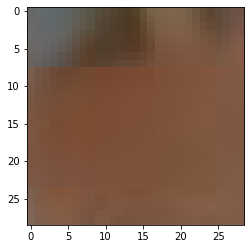

#cubies:  9
F


c:\Users\kovec\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


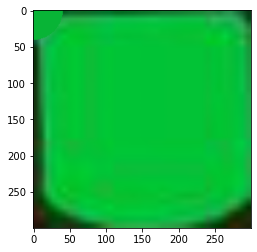

R


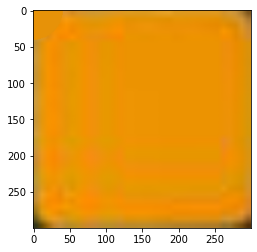

U


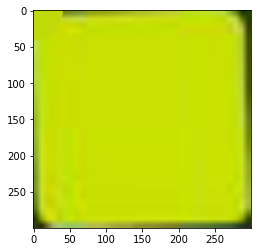

U


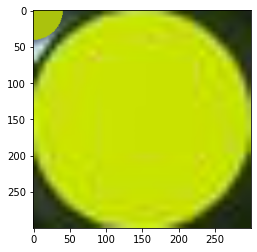

U


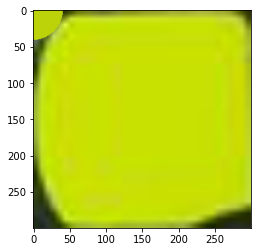

L


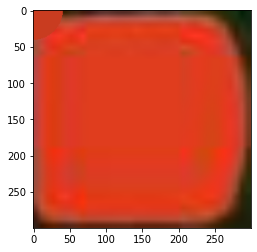

B


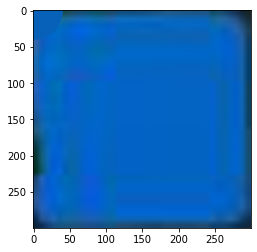

F


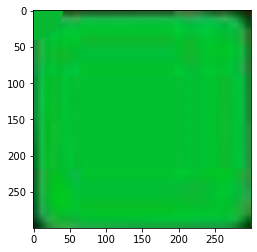

U


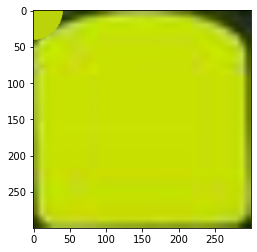

In [140]:
cubies = [] #chooped pic of good cubies
cubie_coords = [] #coordinates of good cubies
face = [] #saving cubies with colors: RGBYOW

#border = -1*int(meanarea*0.02)
border=0
#print(border)

#defining a simple euclidean distance metric on color difference source: wiki

orig_img = plt.imread(path)

i = 0
for cubie in cut_cubies:
    cubiearea = (cubie[2]-cubie[0])*(cubie[3]-cubie[1])
    if cubiearea/meanarea >1.3 or cubiearea/meanarea<0.7:
      print("thisis bad")
      plt.imshow(orig_img[(cubie[0]-border):(cubie[2]+border),(cubie[1]-border):(cubie[3]+border)])
      plt.show()
      #del cut_cubies[i]
      continue
    #i+=1

    if cubie[0]-border>0 and cubie[1]-border>0:

      cubie_pic1 = orig_img[(cubie[0]-border):(cubie[2]+border),(cubie[1]-border):(cubie[3]+border)] #chopped cubie pic if not at the border
      cube_color = cv2.cvtColor(cubie_pic1, cv2.COLOR_BGR2HSV)
      average_color_row = np.average(cubie_pic1, axis=0)
      average_color = np.average(average_color_row, axis=0)

      cubies.append([cv2.resize(cubie_pic1,(300,300)), color_picker(average_color)])
      cubie_coords.append(cubie)
    else:
      cubie_pic2 = orig_img[(cubie[0]):(cubie[2]),(cubie[1]):(cubie[3])] #if cubie at border
      cube_color = cv2.cvtColor(cubie_pic2, cv2.COLOR_BGR2HSV)
      average_color_row = np.average(cubie_pic2, axis=0)
      average_color = np.average(average_color_row, axis=0)

      cubies.append([cv2.resize(cubie_pic2,(300,300)),color_picker(average_color)])
      cubie_coords.append(cubie)

cubie_coords_arr = np.array(cubie_coords)


print("#cubies: ", np.shape(cubies)[0])  



for cube in cubies:
  cube_color = cv2.cvtColor(cube[0], cv2.COLOR_BGR2HSV)
  average_color_row = np.average(cube[0], axis=0)
  average_color = np.average(average_color_row, axis=0)
  #print(average_color)
  print(color_picker(average_color))




  cv2.circle(cube[0], (0, 0), 20, average_color, 40)
  plt.imshow(cube[0])
  plt.show()



Locating the colors on the 3x3 cube face

In [141]:
print(cubie_coords)

#sorting the hegight and width coordinates, then choosing the proper one in the given place

[[202, 114, 239, 152], [203, 161, 239, 197], [204, 71, 241, 108], [247, 116, 285, 154], [247, 161, 284, 198], [248, 71, 286, 108], [292, 162, 329, 199], [293, 72, 330, 109], [293, 117, 330, 154]]


Defining clustering function

Defining the color locator function. Storing the coordinates and colors of each cubie

In [142]:
def cubie_colors(cut_cubies, meanarea, meanside, border=0):

  cubies = [] #chooped pic of good cubies
  cubie_coords = [] #coordinates of good cubies
  face = [] #saving cubies with colors: RGBYOW

  orig_img = plt.imread(path)

  i = 0
  for cubie in cut_cubies:
      cubiearea = (cubie[2]-cubie[0])*(cubie[3]-cubie[1])
      if cubiearea/meanarea >1.3 or cubiearea/meanarea<0.7:
        continue

      cubie_coords.append(cubie)

      if cubie[0]-border>0 and cubie[1]-border>0:

        cubie_pic1 = orig_img[(cubie[0]-border):(cubie[2]+border),(cubie[1]-border):(cubie[3]+border)] #chopped cubie pic if not at the border
        cube_color = cv2.cvtColor(cubie_pic1, cv2.COLOR_BGR2HSV)
        average_color_row = np.average(cubie_pic1, axis=0)
        average_color = np.average(average_color_row, axis=0)

        cubies.append([cv2.resize(cubie_pic1,(300,300)), color_picker(average_color)])
      else:
        cubie_pic2 = orig_img[(cubie[0]):(cubie[2]),(cubie[1]):(cubie[3])] #if cubie at border
        cube_color = cv2.cvtColor(cubie_pic2, cv2.COLOR_BGR2HSV)
        average_color_row = np.average(cubie_pic2, axis=0)
        average_color = np.average(average_color_row, axis=0)

        cubies.append([cv2.resize(cubie_pic2,(300,300)),color_picker(average_color)])

  cubie_coords_arr = np.array(cubie_coords)
  print("coordshape_colorfun: ",np.shape(cubie_coords_arr))
  
  return cubie_coords_arr, cubies

Finding the order of color on the cube faces. First find center piece which has 9 neighbours, then compare each cubie's coordinates to the center one's

In [143]:

def cubie_locator(cubie_coords_arr,cubies, meanside):
    tol = meanside*0.2
    #cubie_coords_arr contains the coordinates of top left corner of clustered cubies 
    #cubies contains the colors of the clustered cubies 
    #meanside is the median side of clustered cuvies's quare
    #tol is the tolerance value for the mislocated rows and cols

    a=np.zeros((9,2))
    #print("type",type(cubie_coords_arr))
    #print("cubies type",type(cubies))

    a = cubie_coords_arr 
    #print(a)

    neighs = np.zeros((9,2)) #neighbours 

    face = [0 for i in range(0,9)] #save cubie colors on face here
    #face[0] = cubie[0][-1]
    
    #print(cubie[0][-1])

    #find center piece
    for i in range(9):
        neignum = 0
        for j in range(9):
            if j != i:

                if abs(a[i][0]-a[j][0])<tol and abs(a[j][1]-a[i][1])>tol and abs(a[j][1]-a[i][1])<meanside*1.5:  #horizontal neighbours
                    #print("vertical", a[i], a[j])
                    neignum+=1

                if abs(a[i][1]-a[j][1])<tol and (abs(a[j][0]-a[i][0]))>tol and abs(a[j][0]-a[i][0])<meanside*1.5: #vertical neighbours
                    neignum+=1
                    #print("horizontal", a[i], a[j])

        neighs[i,0] = i
        neighs[i,1] = neignum
        #print("neignums", i, neignum)

    center = a[np.argmax(neighs[:,1])]
    #print("neighs: ", neighs[:][1])
    print("center_locator", center)


    #locate cubies relative to center piece
    for i in range(9):

        if abs(a[i][0]-center[0])<tol and abs(a[i][1]-center[1])<tol:
            continue

        if a[i][0]+tol<center[0] and a[i][1]+tol<center[1]:  
            print("top left:", a[i], cubies[i][-1])
            face[0]=cubies[i][-1]

        elif a[i][0]+tol<center[0] and abs(a[i][1]-center[1])<tol:  
            #print("top mid:", a[i], cubies[i][-1])
            face[1]=cubies[i][-1]

        elif a[i][0]+tol<center[0] and a[i][1]>center[1]+tol:  
            #print("top right:", a[i], cubies[i][-1])
            face[2]=cubies[i][-1]

        elif abs(a[i][0]-center[0])<tol and a[i][1]+tol<center[1]:  
            #print("mid left", a[i], cubies[i][-1])
            face[3]=cubies[i][-1]

        elif abs(a[i][0]-center[0])<tol and a[i][1]>center[1]+tol:  
            #print("mid right", a[i], cubies[i][-1])
            face[5]=cubies[i][-1]

        elif a[i][0]>center[0]+tol and a[i][1]+tol<center[1]:  
            #print("bot left:", a[i], cubies[i][-1])
            face[6]=cubies[i][-1]

        elif a[i][0]>center[0]+tol and abs(a[i][1]-center[1])<tol:  
            #print("bot mid:", a[i], cubies[i][-1])
            face[7]=cubies[i][-1]

        elif a[i][0]>center[0]+tol and a[i][1]>center[1]+tol:  
            print("bot right:", a[i], cubies[i][-1])
            face[8]=cubies[i][-1]

    #print("center: ", a[np.argmax(neighs[:,1])], cubies[np.argmax(neighs[:,1])][-1])
    face[4]=cubies[np.argmax(neighs[:,1])][-1]
    
    return face

def flatlist(list):
    flatlist = []
    for sublist in list:
        for item in sublist:
            flatlist.append(item)
    return flatlist

cubie_coords_arr, cubies = cubie_colors(cut_cubies, meanarea, meanside)


print("coordsshape: ",np.shape(cubie_coords_arr ))
print("coords: \n", cubie_coords_arr)


face = cubie_locator(cubie_coords_arr, cubies, meanside)

print(face)


coordshape_colorfun:  (9, 4)
coordsshape:  (9, 4)
coords: 
 [[202 114 239 152]
 [203 161 239 197]
 [204  71 241 108]
 [247 116 285 154]
 [247 161 284 198]
 [248  71 286 108]
 [292 162 329 199]
 [293  72 330 109]
 [293 117 330 154]]
center_locator [247 116 285 154]
top left: [204  71 241 108] U
bot right: [292 162 329 199] B
['U', 'F', 'R', 'L', 'U', 'U', 'F', 'U', 'B']


MEGVAAAAAAAN!!!!!!!!

-a nullak azert vannak mert nem mindig megy be abba az if agba :(

6.jpg-n 10 cubie van vegul



valamiert a cubies es a cubie coords nem azonos sorrendben van nemtom miert
vagy az hogy amikor kepet valtoztatsz akkor a cubie locator azonos kep elso futasnal mas eredmenyt ad mint a kovinel

ha csak ezt a cellat futtatom le akkor mas eredmenyt ad mintha run all-t nyomnek - ez azert van mert a run all utan az utolso erteket nezi pl az img-nek es onnan szamol

Working method

In [144]:
cubie_coords_arr, cubies = cubie_colors(cut_cubies, meanarea, meanside)

print("coordsshape: ",np.shape(cubie_coords_arr ))
print("coords: \n", cubie_coords_arr)


face = cubie_locator(cubie_coords_arr, cubies, meanside)

print(face)

coordshape_colorfun:  (9, 4)
coordsshape:  (9, 4)
coords: 
 [[202 114 239 152]
 [203 161 239 197]
 [204  71 241 108]
 [247 116 285 154]
 [247 161 284 198]
 [248  71 286 108]
 [292 162 329 199]
 [293  72 330 109]
 [293 117 330 154]]
center_locator [247 116 285 154]
top left: [204  71 241 108] U
bot right: [292 162 329 199] B
['U', 'F', 'R', 'L', 'U', 'U', 'F', 'U', 'B']


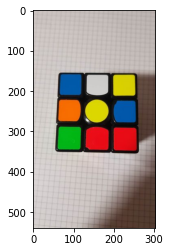

coordshape_colorfun:  (9, 4)
center_locator [222 129 278 186]
top left: [159  66 211 120] B
bot right: [291 200 348 256] L
1 ['B', 'D', 'U', 'R', 'U', 'B', 'F', 'L', 'L'] center pos:  0


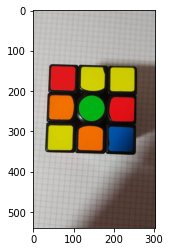

coordshape_colorfun:  (9, 4)
center_locator [212 113 275 177]
top left: [140  44 199 104] L
bot right: [289 186 350 248] B
2 ['L', 'U', 'U', 'R', 'F', 'L', 'U', 'R', 'B'] center pos:  2


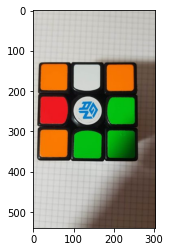

coordshape_colorfun:  (9, 4)
center_locator [215 100 284 170]
top left: [134  19 199  85] R
bot right: [298 184 366 250] F
3 ['R', 'D', 'R', 'L', 'D', 'F', 'R', 'F', 'F'] center pos:  3


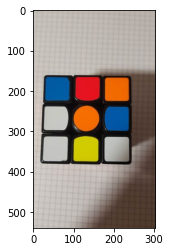

coordshape_colorfun:  (9, 4)
center_locator [237 101 300 164]
top left: [166  30 224  90] B
bot right: [314 177 375 235] D
4 ['B', 'L', 'R', 'D', 'R', 'B', 'D', 'U', 'D'] center pos:  1


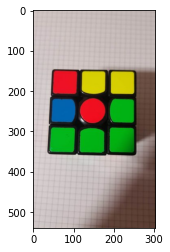

coordshape_colorfun:  (9, 4)
center_locator [219 117 280 178]
top left: [150  50 208 108] L
bot right: [291 189 352 249] F
5 ['L', 'U', 'U', 'B', 'L', 'F', 'F', 'F', 'F'] center pos:  4


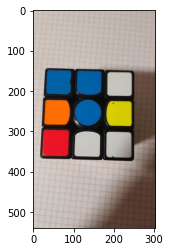

coordshape_colorfun:  (9, 4)
center_locator [222 104 286 169]
top left: [149  33 209  95] B
bot right: [302 181 365 242] D
6 ['B', 'B', 'D', 'R', 'B', 'U', 'L', 'D', 'D'] center pos:  5
cube_state ['B', 'D', 'U', 'R', 'U', 'B', 'F', 'L', 'L', 'B', 'L', 'R', 'D', 'R', 'B', 'D', 'U', 'D', 'L', 'U', 'U', 'R', 'F', 'L', 'U', 'R', 'B', 'R', 'D', 'R', 'L', 'D', 'F', 'R', 'F', 'F', 'L', 'U', 'U', 'B', 'L', 'F', 'F', 'F', 'F', 'B', 'B', 'D', 'R', 'B', 'U', 'L', 'D', 'D']


In [169]:
cube_state = [[0]]*6 #the order of colors on the whole cube

for i in range(1,7):
    path = f"case1/cube{i}.jpg"
    
    orig_img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.show()

    cut_cubies, meanarea = clustering(img)
    meanside = int(np.sqrt(meanarea))

    cubie_coords_arr, cubies = cubie_colors(cut_cubies,meanarea,meanside)

    curr_face = cubie_locator(cubie_coords_arr,cubies, meanside)

    cube_state[color_names.index(curr_face[4])] = curr_face

    print(i,curr_face, "center pos: ", color_names.index(curr_face[4]))



print("cube_state", flatlist(cube_state))

#print(color_names.index(cubie_locator(cubie_coords_arr,cubies, meanside)[4]))




In [170]:
cube_input = ''

for i in range (len(cube_state)):
    for j in range(9):
        cube_input = cube_input + cube_state[i][j]

print(cube_input)

kociemba.solve(cube_input)

BDURUBFLLBLRDRBDUDLUURFLURBRDRLDFRFFLUUBLFFFFBBDRBULDD


"R F' L' B2 U2 L B' D' F' B L U2 F2 U D' F2 D R2 L2 U' F2"